In [1]:
# Import Libraries - Enhanced for Statistical Analysis
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Set Up Database Connection
# Replace the placeholders with your actual database credentials
DB_CONFIG = {
    "dbname": "csgo_parsed",
    "user": "csgo_parser",
    "password": "3?6B7yTGPrkJF34p",
    "host": "192.168.1.100",
    "port": "5444"
}

In [2]:


# Ensure we have a fresh connection
try:
    conn = psycopg2.connect(**DB_CONFIG)
    print("✅ Database connection established")
except Exception as e:
    print(f"❌ Connection error: {e}")

def get_descriptive_stats(data, column_name):
    """Calculate comprehensive descriptive statistics"""
    stats_dict = {
        'count': len(data),
        'min': data.min(),
        'max': data.max(),
        'mean': data.mean(),
        'median': data.median(),
        'std': data.std(),
        'q25': data.quantile(0.25),
        'q75': data.quantile(0.75)
    }
    return stats_dict

def get_top_values(data, n=15):
    """Get top N occurring values with percentages"""
    value_counts = data.value_counts().head(n)
    percentages = (value_counts / len(data) * 100).round(2)
    return pd.DataFrame({
        'value': value_counts.index,
        'count': value_counts.values,
        'percentage': percentages.values
    })

def create_distribution_plots(data, title, bins=50):
    """Create histogram and box plot for a variable"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram
    ax1.hist(data.dropna(), bins=bins, alpha=0.7, edgecolor='black')
    ax1.set_title(f'{title} - Distribution')
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency')
    ax1.grid(True, alpha=0.3)
    
    # Box plot
    ax2.boxplot(data.dropna())
    ax2.set_title(f'{title} - Box Plot')
    ax2.set_ylabel('Value')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("📊 Helper functions defined successfully!")


✅ Database connection established
📊 Helper functions defined successfully!


In [3]:
# Query for detailed round outcomes

#TODO: some values cannot be used if a player is missing at RS of a round (or even FTE for that matter). In those cases, the sums will be off.
#SQL should return a NaN or NULL in those cases, in order for me to use the rest of the round level data without excluding everything. 

query_detailed = """
WITH round_equipment AS (
    SELECT 
        r.id,
        r.match_id,
        r.id_demo_exports,
        r.round_num,
        r.ct_winner,
        r.team1_winner,
        r.is_ct_t1,
        r.round_end_reason,
        -- CT team equipment
        SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) as ct_equipment,
        -- T team equipment
        SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) as t_equipment,
        r.t1_score_end,
        r.t2_score_end,
        r.t1_score_start,
        r.t2_score_start,
        hmi.team_1_id,
        hmi.team_2_id,
        hmi.event_id
    FROM rounds_ed r
    JOIN player_round_ed pr ON r.id = pr.round_id
    LEFT JOIN hltv_match_info hmi ON r.match_id = hmi.match_id
    WHERE pr.eq_val_fte > 0
    GROUP BY 1,2,3,4,5,6,7,8, 11,12,13, 14,15,16,17
),
bomb_planted AS (
    SELECT 
        round_id,
        CASE WHEN COUNT(*) > 0 THEN 1 ELSE 0 END as bomb_planted
    FROM bomb_events_round_ed
    WHERE bomb_event_type = 0
    GROUP BY round_id
),
round_survivors AS (
    SELECT 
        r.id as round_id,
        r.is_ct_t1,
        -- Count total players per team (5 players each)
        -- CT survivors = 5 - (deaths of CT players)
        5 - COUNT(DISTINCT CASE 
            WHEN (r.is_ct_t1 = (pv.team = 1)) THEN k.victim_hltv_id 
        END) as ct_survivors,
        -- T survivors = 5 - (deaths of T players)
        5 - COUNT(DISTINCT CASE 
            WHEN (r.is_ct_t1 != (pv.team = 1)) THEN k.victim_hltv_id 
        END) as t_survivors
    FROM rounds_ed r
    LEFT JOIN kills_round_ed k ON r.id = k.round_id
    LEFT JOIN player_round_ed pv ON k.victim_hltv_id = pv.player_id AND k.round_id = pv.round_id and pv.player_id != 0
    GROUP BY 1,2
),
saved_equipment AS (
    SELECT 
        r.id as round_id,
        r.is_ct_t1,
        -- CT team saved equipment from player_economy_ed joined with player_round_ed
        SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN COALESCE(pe.saved_eq_val, 0) ELSE 0 END) as ct_saved_equipment,
        SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN COALESCE(pe.starting_eq_val, 0) ELSE 0 END) as ct_starting_equipment,
        -- T team saved equipment from player_economy_ed joined with player_round_ed
        SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN COALESCE(pe.saved_eq_val, 0) ELSE 0 END) as t_saved_equipment,
        SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN COALESCE(pe.starting_eq_val, 0) ELSE 0 END) as t_starting_equipment
    FROM rounds_ed r
    JOIN player_economy_ed pe ON r.id = pe.round_id
    JOIN player_round_ed pr ON r.id = pr.round_id AND pe.player_id = pr.player_id and pr.player_id != 0
    GROUP BY 1,2
),
team_money AS (
    SELECT 
        r.id as round_id,
        r.is_ct_t1,
        -- CT team player money (money_earned + money_earned_re) joined with player_round_ed
        CASE WHEN COUNT(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) AND (pe.money_earned = 0 OR pe.money_earned IS NULL) THEN 1 END) > 0 
            OR SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN 1 ELSE 0 END) = 0
            THEN NULL 
            ELSE SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN pe.money_earned ELSE 0 END) 
        END as ct_money_earned,
        -- CT team player money at start 
        CASE WHEN COUNT(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) AND (pe.money_start = 0 OR pe.money_start IS NULL) THEN 1 END) > 0 
            OR SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN 1 ELSE 0 END) = 0
            THEN NULL 
            ELSE SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN pe.money_start ELSE 0 END) 
        END as ct_money_start,
        -- CT team player money spent (no zero check)
        CASE WHEN COUNT(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) AND pe.money_spent IS NULL THEN 1 END) > 0 
            THEN NULL 
            ELSE SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN pe.money_spent ELSE 0 END) 
        END as ct_money_spent,
        -- T team player money (money_earned + money_earned_re) joined with player_round_ed
        CASE WHEN COUNT(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) AND (pe.money_earned = 0 OR pe.money_earned IS NULL) THEN 1 END) > 0 
            OR SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN 1 ELSE 0 END) = 0
            THEN NULL 
            ELSE SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN pe.money_earned ELSE 0 END) 
        END as t_money_earned,
        -- T team player money at start 
        CASE WHEN COUNT(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) AND (pe.money_start = 0 OR pe.money_start IS NULL) THEN 1 END) > 0 
            OR SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN 1 ELSE 0 END) = 0
            THEN NULL 
            ELSE SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN pe.money_start ELSE 0 END) 
        END as t_money_start,
        -- T team player money spent (no zero check)
        CASE WHEN COUNT(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) AND pe.money_spent IS NULL THEN 1 END) > 0 
            THEN NULL 
            ELSE SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN pe.money_spent ELSE 0 END) 
        END as t_money_spent
    FROM rounds_ed r
    JOIN player_economy_ed pe ON r.id = pe.round_id
    JOIN player_round_ed pr ON r.id = pr.round_id AND pe.player_id = pr.player_id and pr.player_id != 0
    GROUP BY 1,2
),
ranked_data AS (
    SELECT 
        trd.id,
        trd.id_demo_exports,
        trd.round_num,
        trd.team1_winner,
        -- Team 1 metrics
        COALESCE(CAST(het1.rank_during AS INTEGER), 999) as t1_rank,
        -- Team 2 metrics
        COALESCE(CAST(het2.rank_during AS INTEGER), 999) as t2_rank
    FROM round_equipment trd
    LEFT JOIN hltv_events_teams het1 ON het1.team_id = trd.team_1_id AND het1.event_id = trd.event_id
    LEFT JOIN hltv_events_teams het2 ON het2.team_id = trd.team_2_id AND het2.event_id = trd.event_id
),
previous_round_stats AS (
    SELECT 
        r.id as round_id,
        r.id_demo_exports,
        r.round_num,
        COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 = (pr_prev.team = 1)) THEN COALESCE(pr_prev.kills, 0) ELSE 0 END), 0) as ct_prev_kills,
        COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 != (pr_prev.team = 1)) THEN COALESCE(pr_prev.kills, 0) ELSE 0 END), 0) as t_prev_kills,
        COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 = (pr_prev.team = 1)) THEN COALESCE(pr_prev.assists, 0) ELSE 0 END), 0) as ct_prev_assists,
        COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 != (pr_prev.team = 1)) THEN COALESCE(pr_prev.assists, 0) ELSE 0 END), 0) as t_prev_assists,
        COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 = (pr_prev.team = 1)) THEN COALESCE(pr_prev.deaths, 0) ELSE 0 END), 0) as ct_prev_deaths,
        COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 != (pr_prev.team = 1)) THEN COALESCE(pr_prev.deaths, 0) ELSE 0 END), 0) as t_prev_deaths
    FROM rounds_ed r
    LEFT JOIN rounds_ed r_prev ON r.id_demo_exports = r_prev.id_demo_exports 
        AND r_prev.round_num = r.round_num - 1 
        AND r.round_num > 1
    LEFT JOIN player_round_ed pr_prev ON r_prev.id = pr_prev.round_id AND pr_prev.player_id != 0
    GROUP BY 1,2,3
),
streaks as (
    SELECT 
    rse.round_id,
    rse.id_demo_exports,
    rse.round_num,
    rse.t1_win_streak,
    rse.t1_loss_streak,
    rse.t1_win_streak_cons,
    rse.t1_loss_streak_cons,
    rse.t2_win_streak,
    rse.t2_loss_streak,
    rse.t2_win_streak_cons,
    rse.t2_loss_streak_cons,
    COALESCE(rse.t1_win_streak, 0) as t1_win_streak_prev,
    COALESCE(rse.t1_loss_streak, 0) as t1_loss_streak_prev,
    COALESCE(rse.t1_win_streak_cons, 0) as t1_win_streak_cons_prev ,
    COALESCE(rse.t1_loss_streak_cons, 0) as t1_loss_streak_cons_prev ,
    COALESCE(rse.t2_win_streak, 0) as t2_win_streak_prev,
    COALESCE(rse.t2_loss_streak, 0) as t2_loss_streak_prev,
    COALESCE(rse.t2_win_streak_cons, 0) as t2_win_streak_cons_prev,
    COALESCE(rse.t2_loss_streak_cons, 0) as t2_loss_streak_cons_prev
    FROM round_streaks_ed rse
    -- loockback part
    LEFT JOIN round_streaks_ed rse_prev ON rse.id_demo_exports = rse_prev.id_demo_exports 
        AND rse_prev.round_num = rse.round_num - 1 
        AND rse.round_num > 1
)

SELECT 
    re.*,
    -- Add bomb planted status
    COALESCE(bp.bomb_planted, 0) as bomb_planted,
    -- Add survivor counts from round_survivors CTE
    rs.ct_survivors,
    rs.t_survivors,
    -- Higher and lower equipment
    CASE 
        WHEN re.ct_equipment > re.t_equipment THEN re.ct_equipment
        ELSE re.t_equipment
    END as higher_equipment,
    CASE 
        WHEN re.ct_equipment <= re.t_equipment THEN re.ct_equipment
        ELSE re.t_equipment
    END as lower_equipment,
    -- Did higher equipment team win?
    CASE 
        WHEN (re.ct_equipment > re.t_equipment AND re.ct_winner)
        OR (re.ct_equipment < re.t_equipment AND NOT re.ct_winner)
        THEN 1
        ELSE 0
    END as higher_eq_won,
    -- Winner's survivors (only from is_alive_re)
    CASE 
        WHEN re.ct_winner THEN rs.ct_survivors
        ELSE rs.t_survivors
    END as winner_survivors,
    -- Winner's saved equipment (from player_economy_ed.saved_eq_val)
    CASE 
        WHEN re.ct_winner THEN se.ct_saved_equipment
        ELSE se.t_saved_equipment
    END as winner_saved_equipment,
    -- CT and T saved equipment 
    se.ct_saved_equipment,
    se.ct_starting_equipment,
    se.t_saved_equipment,
    se.t_starting_equipment,
    -- All money columns for analysis
    tm.ct_money_earned,
    tm.ct_money_start,
    tm.ct_money_spent,
    tm.t_money_earned,
    tm.t_money_start,
    tm.t_money_spent,
    -- Previous round stats
    prs.ct_prev_kills,
    prs.t_prev_kills,
    prs.ct_prev_assists,
    prs.t_prev_assists,
    prs.ct_prev_deaths,
    prs.t_prev_deaths,
    -- Ranked data
    rd.t1_rank,
    rd.t2_rank,
    -- streaks data
    st.t1_win_streak,
    st.t1_loss_streak,
    st.t1_win_streak_cons,
    st.t1_loss_streak_cons,
    st.t2_win_streak,
    st.t2_loss_streak,
    st.t2_win_streak_cons,
    st.t2_loss_streak_cons,
    st.t1_win_streak_prev, 
    st.t1_loss_streak_prev, 
    st.t1_win_streak_cons_prev, 
    st.t1_loss_streak_cons_prev, 
    st.t2_win_streak_prev, 
    st.t2_loss_streak_prev, 
    st.t2_win_streak_cons_prev, 
    st.t2_loss_streak_cons_prev
FROM round_equipment re
LEFT JOIN bomb_planted bp ON re.id = bp.round_id
LEFT JOIN round_survivors rs ON re.id = rs.round_id
LEFT JOIN saved_equipment se ON re.id = se.round_id
LEFT JOIN previous_round_stats prs ON re.id = prs.round_id
LEFT JOIN team_money tm ON re.id = tm.round_id
LEFT JOIN ranked_data rd ON re.id = rd.id
LEFT JOIN streaks st ON re.id = st.round_id
WHERE re.ct_equipment > 0 AND re.t_equipment > 0 
ORDER BY re.id_demo_exports, re.round_num
"""

print("📊 Fetching detailed round data...")
detailed_df = pd.read_sql_query(query_detailed, conn)
print(f"✅ Loaded {len(detailed_df):,} rounds with complete data")
print()

# Combine round end reasons 12 and 7
print("🔹 Pre-processing: Combining round end reasons 12 and 7")
detailed_df['round_end_reason'] = detailed_df['round_end_reason'].replace({12: 7})
print(f"   Round end reasons 12 merged into 7")
print()

# Recode round end reasons: 1→1, 9→2, 7→3, 8→4
print("🔹 Recoding round end reasons")
original_count = len(detailed_df)
print(f"   Original distribution:")
for old_code in [1, 7, 8, 9]:
    count = (detailed_df['round_end_reason'] == old_code).sum()
    pct = count / len(detailed_df) * 100 if len(detailed_df) > 0 else 0
    print(f"      Reason {old_code}: {count:,} rounds ({pct:.2f}%)")

detailed_df['round_end_reason'] = detailed_df['round_end_reason'].replace({
    1: 1,  # T Win (Target Bombed) - no change
    9: 2,  # T Win (Elimination) - 9 → 2
    7: 3,  # CT Win (Defuse) - 7 → 3
    8: 4,  # CT Win (Elimination) - 8 → 4
})

print(f"   New distribution:")
for new_code in [1, 2, 3, 4]:
    count = (detailed_df['round_end_reason'] == new_code).sum()
    pct = count / len(detailed_df) * 100 if len(detailed_df) > 0 else 0
    print(f"      Reason {new_code}: {count:,} rounds ({pct:.2f}%)")
print()



📊 Fetching detailed round data...


C:\Users\peter\AppData\Local\Temp\ipykernel_48604\3824994938.py:263: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  detailed_df = pd.read_sql_query(query_detailed, conn)


✅ Loaded 2,760,022 rounds with complete data

🔹 Pre-processing: Combining round end reasons 12 and 7
   Round end reasons 12 merged into 7

🔹 Recoding round end reasons
   Original distribution:
      Reason 1: 432,967 rounds (15.69%)
      Reason 7: 429,400 rounds (15.56%)
      Reason 8: 991,457 rounds (35.92%)
      Reason 9: 906,198 rounds (32.83%)
   New distribution:
      Reason 1: 432,967 rounds (15.69%)
      Reason 2: 906,198 rounds (32.83%)
      Reason 3: 429,400 rounds (15.56%)
      Reason 4: 991,457 rounds (35.92%)



In [4]:


# Filter out inconsistent data
# Reason 2 (T Win Elimination - was 9) should have CT survivors = 0
filtered_9 = (detailed_df['round_end_reason'] == 2) & (detailed_df['ct_survivors'] > 0)

# Find last round of each game
last_round_per_game = detailed_df.groupby('id_demo_exports')['round_num'].max()
is_last_round = detailed_df['round_num'] == detailed_df['id_demo_exports'].map(last_round_per_game)

# Separate last rounds from others
is_last_round_issue = filtered_9 & is_last_round
is_other_issue = filtered_9 & ~is_last_round

reason_9_issues = detailed_df[filtered_9]
print(f"🔹 Filtering inconsistent Reason 2 (T Win Elimination) rounds:")
print(f"   Found {len(reason_9_issues):,} rounds where Reason 2 occurred but CT had survivors > 0")

# Correct ct_survivors to 0 for last round inconsistencies, this can happen as the parser sometimes does not receive the death of the last player
#before the demo is ended
num_corrected = is_last_round_issue.sum()
if num_corrected > 0:
    detailed_df.loc[is_last_round_issue, 'ct_survivors'] = 0
    print(f"   Corrected ct_survivors to 0 for {num_corrected:,} last round inconsistencies")

# Filter out other inconsistencies
before = len(detailed_df)
detailed_df = detailed_df[~is_other_issue]
total_filtered = before - len(detailed_df)

print(f"   Removed: {total_filtered:,} rounds (non-last-round inconsistencies)")
print(f"   Remaining: {len(detailed_df):,} rounds")
print()
print("✅ Data quality filtering complete")

🔹 Filtering inconsistent Reason 2 (T Win Elimination) rounds:
   Found 2,956 rounds where Reason 2 occurred but CT had survivors > 0
   Corrected ct_survivors to 0 for 57 last round inconsistencies
   Removed: 2,899 rounds (non-last-round inconsistencies)
   Remaining: 2,757,123 rounds

✅ Data quality filtering complete


In [5]:
#transforming rank data for ct/t side

detailed_df['ct_rank'] = detailed_df[detailed_df['is_ct_t1'] == 1]['t1_rank'].combine_first(
    detailed_df[detailed_df['is_ct_t1'] == 0]['t2_rank']
)

detailed_df['t_rank'] = detailed_df[detailed_df['is_ct_t1'] == 0]['t1_rank'].combine_first(
    detailed_df[detailed_df['is_ct_t1'] == 1]['t2_rank']
)

In [6]:
print("="*80)
print("DATAFRAME COLUMNS")
print("="*80)
print()

print(f"Total Columns: {len(detailed_df.columns)}")
print()

print("Column List:")
print("-"*80)
for i, col in enumerate(detailed_df.columns, 1):
    dtype = detailed_df[col].dtype
    non_null = detailed_df[col].notna().sum()
    null_pct = (detailed_df[col].isna().sum() / len(detailed_df)) * 100
    print(f"{i:3d}. {col:30s} | Type: {str(dtype):15s} | Non-Null: {non_null:10,d} | Null%: {null_pct:5.1f}%")

print()
print("="*80)
print("DATAFRAME INFO")
print("="*80)
print(f"Shape: {detailed_df.shape[0]:,} rows × {detailed_df.shape[1]} columns")
print(f"Memory Usage: {detailed_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print()

print("Data Types Summary:")
print(detailed_df.dtypes.value_counts())

DATAFRAME COLUMNS

Total Columns: 61

Column List:
--------------------------------------------------------------------------------
  1. id                             | Type: int64           | Non-Null:  2,757,123 | Null%:   0.0%
  2. match_id                       | Type: int64           | Non-Null:  2,757,123 | Null%:   0.0%
  3. id_demo_exports                | Type: int64           | Non-Null:  2,757,123 | Null%:   0.0%
  4. round_num                      | Type: int64           | Non-Null:  2,757,123 | Null%:   0.0%
  5. ct_winner                      | Type: bool            | Non-Null:  2,757,123 | Null%:   0.0%
  6. team1_winner                   | Type: bool            | Non-Null:  2,757,123 | Null%:   0.0%
  7. is_ct_t1                       | Type: bool            | Non-Null:  2,757,123 | Null%:   0.0%
  8. round_end_reason               | Type: int64           | Non-Null:  2,757,123 | Null%:   0.0%
  9. ct_equipment                   | Type: int64           | Non-Null:  2,7

In [7]:
# Analyze economy variables
economy_variables = ['money_spent', 'money_earned', 'money_start', 'equipment', 'spent_ratio', 'invested_ratio', 'saved_equipment_ratio']

economy_df = detailed_df

economy_df['ct_spent_ratio'] = economy_df['ct_money_spent'] / (economy_df['ct_money_start'] + 1)  # Avoid division by zero
economy_df['ct_invested_ratio'] = economy_df['ct_equipment'] / (economy_df['ct_money_start'] + economy_df['ct_starting_equipment'] + 1)  # Avoid division by zero
economy_df['ct_saved_equipment_ratio'] = economy_df['ct_saved_equipment'].replace(0, np.nan) / economy_df['ct_survivors'].replace(0, np.nan)  # Avoid division by zero

economy_df['t_spent_ratio'] = economy_df['t_money_spent'] / (economy_df['t_money_start'] + 1)  # Avoid division by zero
economy_df['t_invested_ratio'] = economy_df['t_equipment'] / (economy_df['t_money_start'] + economy_df['t_starting_equipment'] + 1)  # Avoid division by zero
economy_df['t_saved_equipment_ratio'] = economy_df['t_saved_equipment'].replace(0, np.nan) / economy_df['t_survivors'].replace(0, np.nan)  # Avoid division by zero

#TODOD: as a quick fix while the larger problem is not solved, exclude invested ratio values over 1 (as that should not be possible). 
#There might be multiple underlying reasons for this: 1. players not present at RS cause values to be missed i.e. 0 which skews the sums
#2. potentially defuse kits are not calculated correctly in eq_val_fte
#3. other parser or demos issues

ECONOMY ANALYSIS: CT vs T SIDE-BY-SIDE COMPARISON



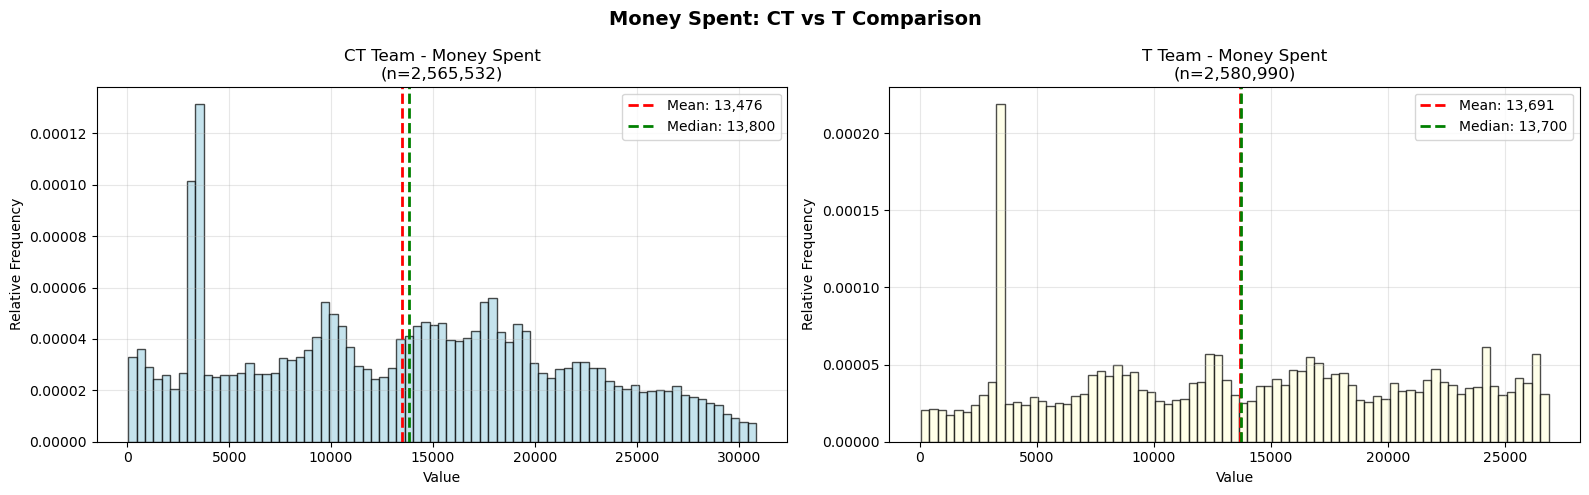

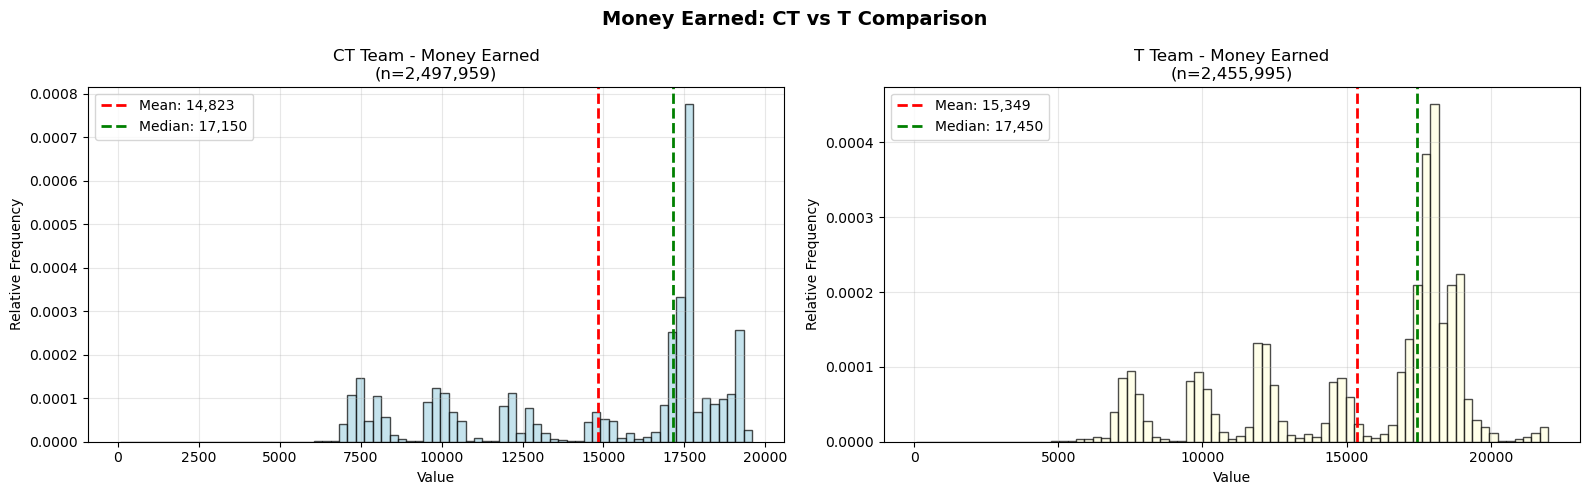

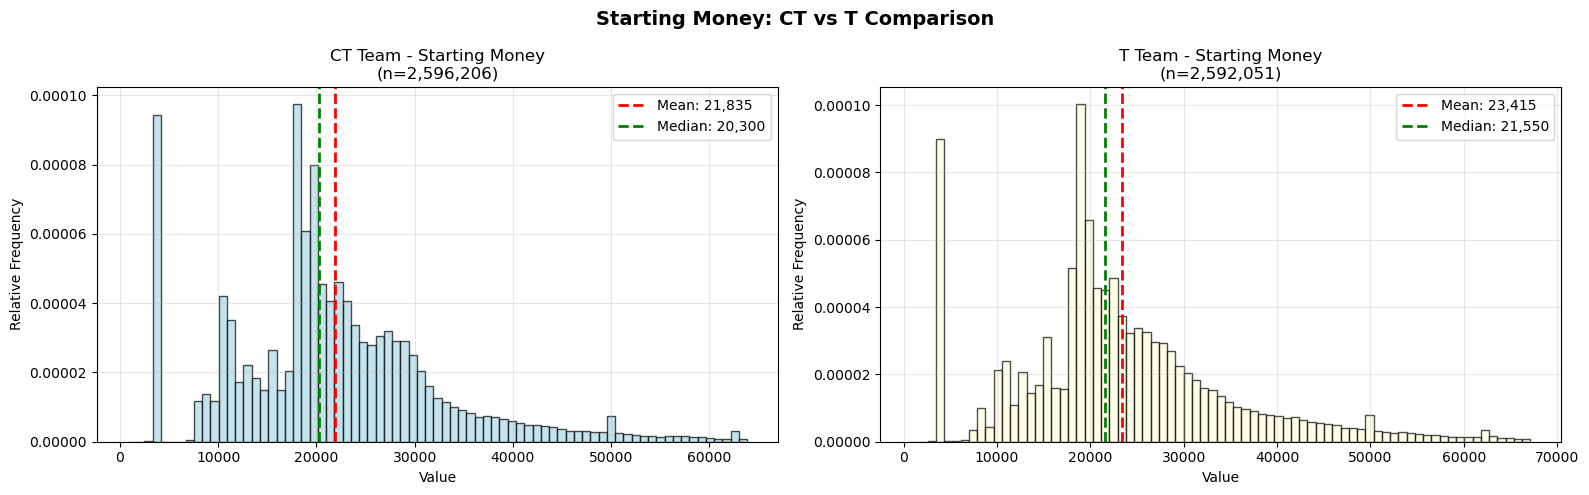

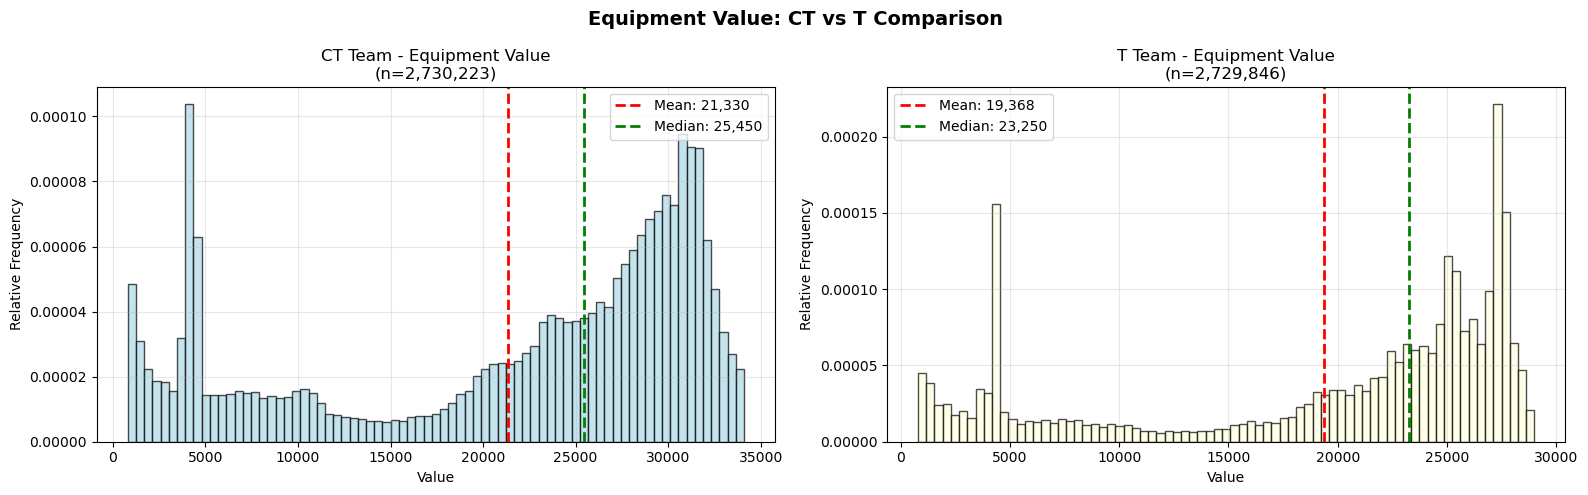

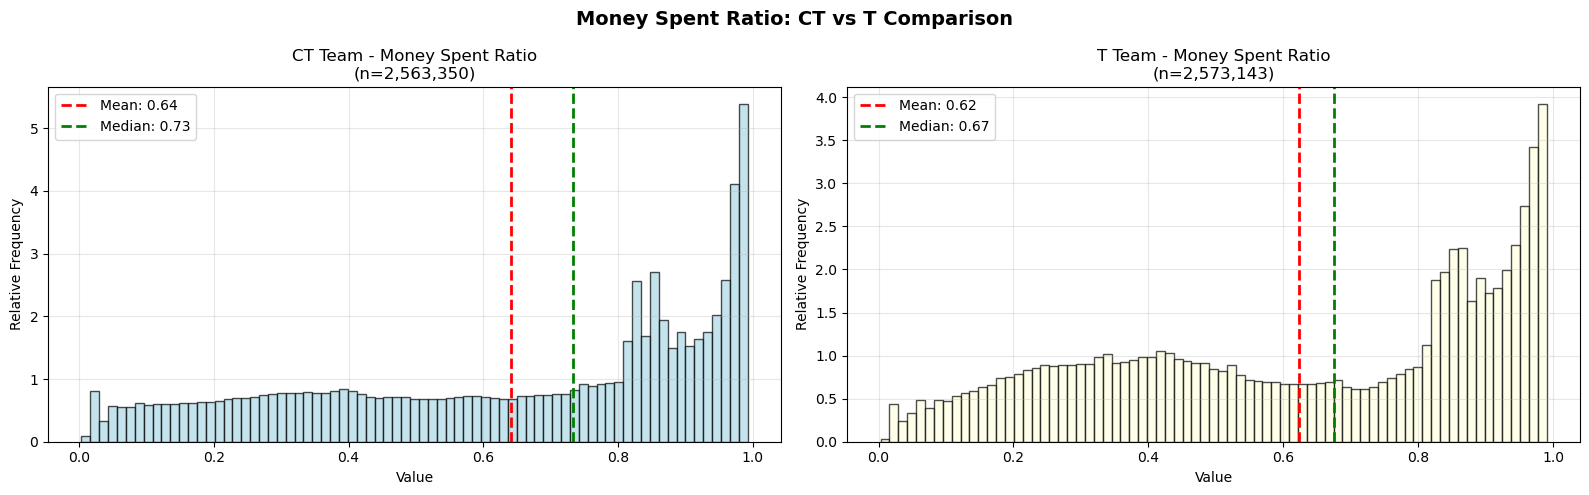

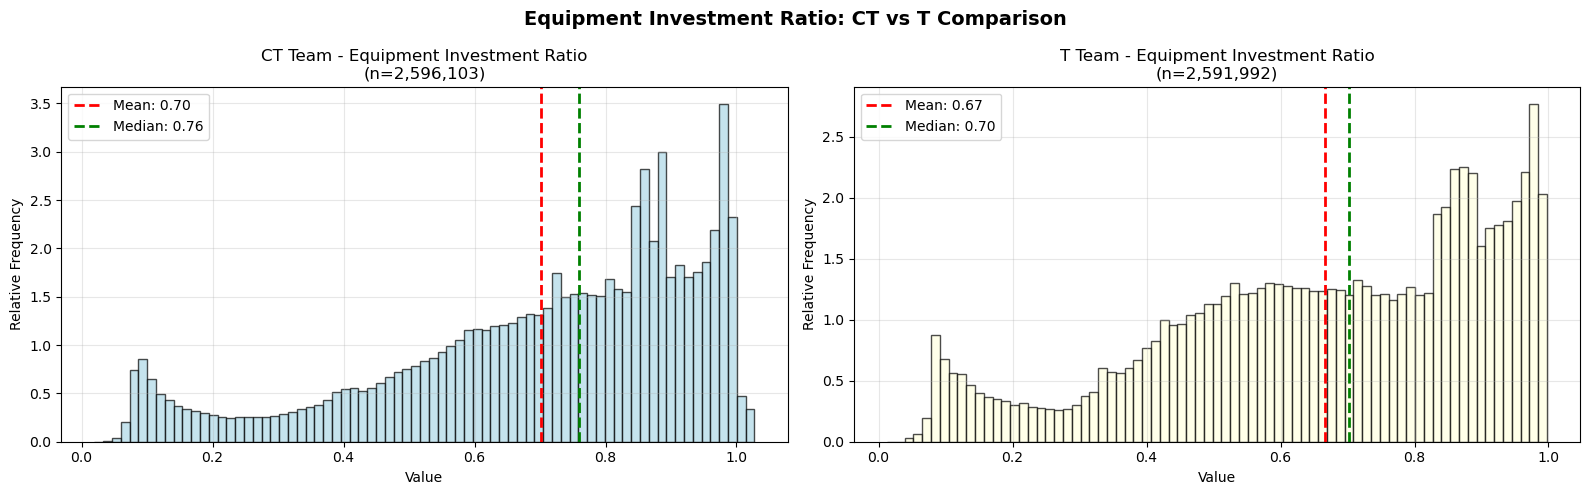

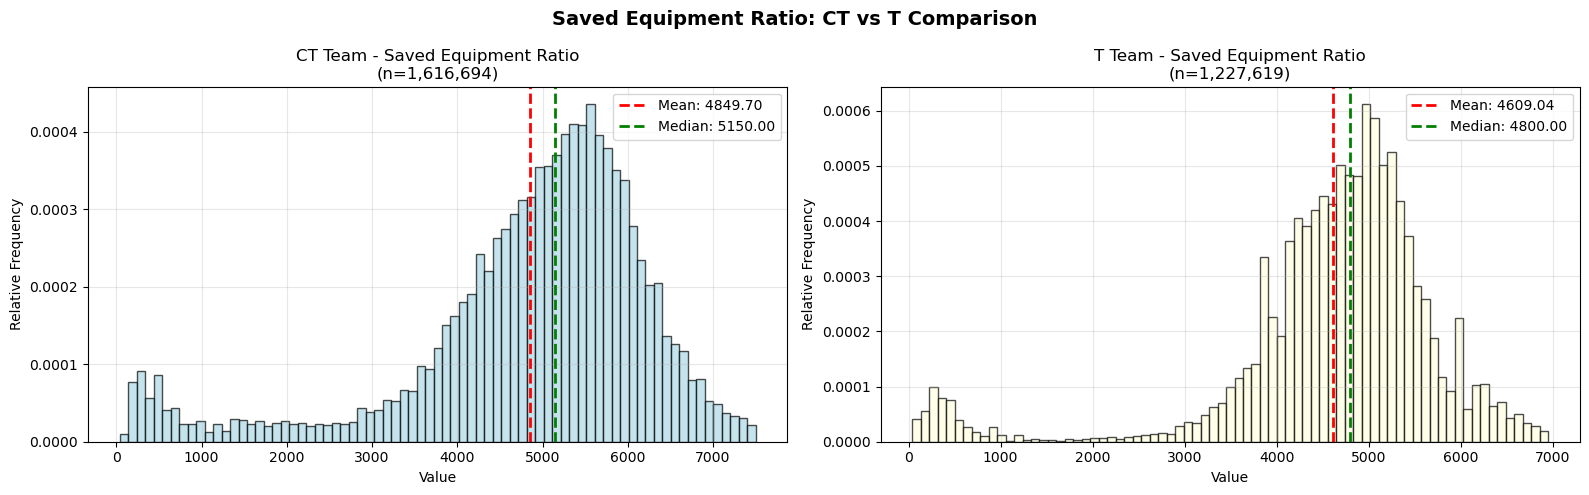

In [8]:
print("="*80)
print("ECONOMY ANALYSIS: CT vs T SIDE-BY-SIDE COMPARISON")
print("="*80)
print()


# Define economy variables for CT and T teams
team_variables = [
    ('ct_money_spent', 't_money_spent', 'Money Spent'),
    ('ct_money_earned', 't_money_earned', 'Money Earned'),
    ('ct_money_start', 't_money_start', 'Starting Money'),
    ('ct_equipment', 't_equipment', 'Equipment Value'),
    ('ct_spent_ratio', 't_spent_ratio', 'Money Spent Ratio'),
    ('ct_invested_ratio', 't_invested_ratio', 'Equipment Investment Ratio'),
    ('ct_saved_equipment_ratio', 't_saved_equipment_ratio', 'Saved Equipment Ratio'),
]

# Create side-by-side comparisons for CT vs T
for ct_var, t_var, label in team_variables:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    fig.suptitle(f'{label}: CT vs T Comparison', fontsize=14, fontweight='bold')
    
    # CT Team Data
    ct_clean = economy_df[ct_var].dropna()
    ct_clean = ct_clean[ct_clean > 0]
    if len(ct_clean) > 0:
        q99 = np.percentile(ct_clean, 99)
        ct_viz = ct_clean[ct_clean <= q99]
        
        axes[0].hist(ct_viz, bins=75, alpha=0.7, color='lightblue', edgecolor='black', density=True)
        ct_mean = ct_viz.mean()
        ct_median = ct_viz.median()
        ct_mean_label = f'{ct_mean:.2f}' if 'ratio' in ct_var else f'{ct_mean:,.0f}'
        ct_median_label = f'{ct_median:.2f}' if 'ratio' in ct_var else f'{ct_median:,.0f}'
        axes[0].axvline(ct_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {ct_mean_label}')
        axes[0].axvline(ct_median, color='green', linestyle='--', linewidth=2, label=f'Median: {ct_median_label}')
        axes[0].set_title(f'CT Team - {label}\n(n={len(ct_viz):,})')
        axes[0].set_xlabel('Value')
        axes[0].set_ylabel('Relative Frequency')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
    else:
        axes[0].text(0.5, 0.5, f'No data for CT {label}', ha='center', va='center')
    
    # T Team Data
    t_clean = economy_df[t_var].dropna()
    t_clean = t_clean[t_clean > 0]
    
    
    if len(t_clean) > 0:
        q99 = np.percentile(t_clean, 99)
        t_viz = t_clean[t_clean <= q99]
        
        axes[1].hist(t_viz, bins=75, alpha=0.7, color='lightyellow', edgecolor='black', density=True)
        t_mean = t_viz.mean()
        t_median = t_viz.median()
        t_mean_label = f'{t_mean:.2f}' if 'ratio' in t_var else f'{t_mean:,.0f}'
        t_median_label = f'{t_median:.2f}' if 'ratio' in t_var else f'{t_median:,.0f}'
        axes[1].axvline(t_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {t_mean_label}')
        axes[1].axvline(t_median, color='green', linestyle='--', linewidth=2, label=f'Median: {t_median_label}')
        axes[1].set_title(f'T Team - {label}\n(n={len(t_viz):,})')
        axes[1].set_xlabel('Value')
        axes[1].set_ylabel('Relative Frequency')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, f'No data for T {label}', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
    





ECONOMY ANALYSIS: COMBINED TEAMS (CT + T)



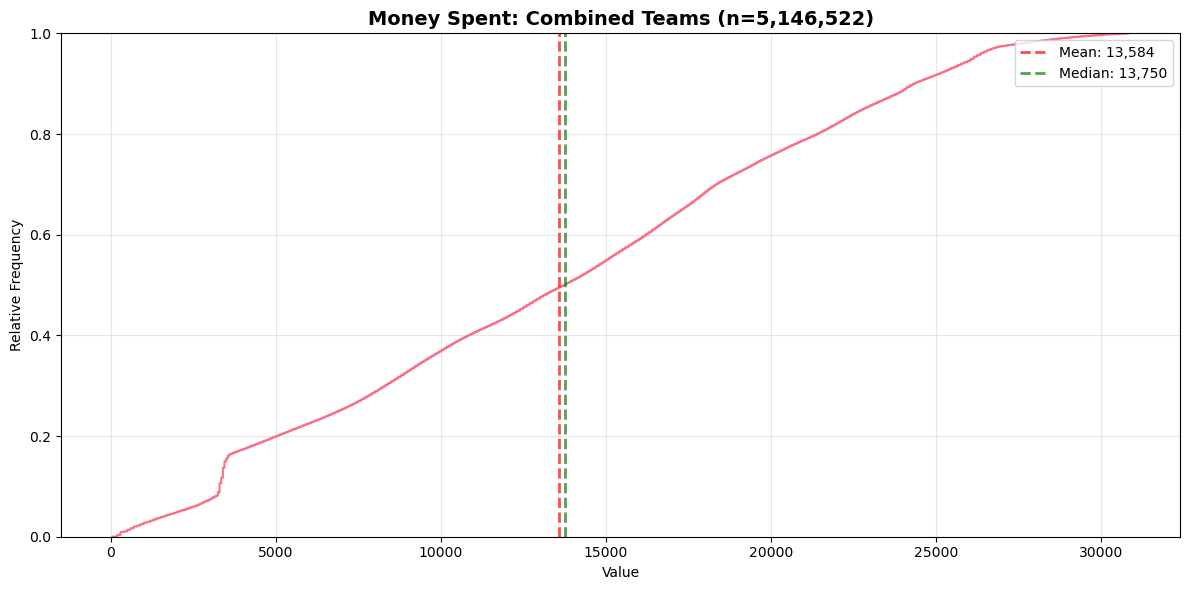

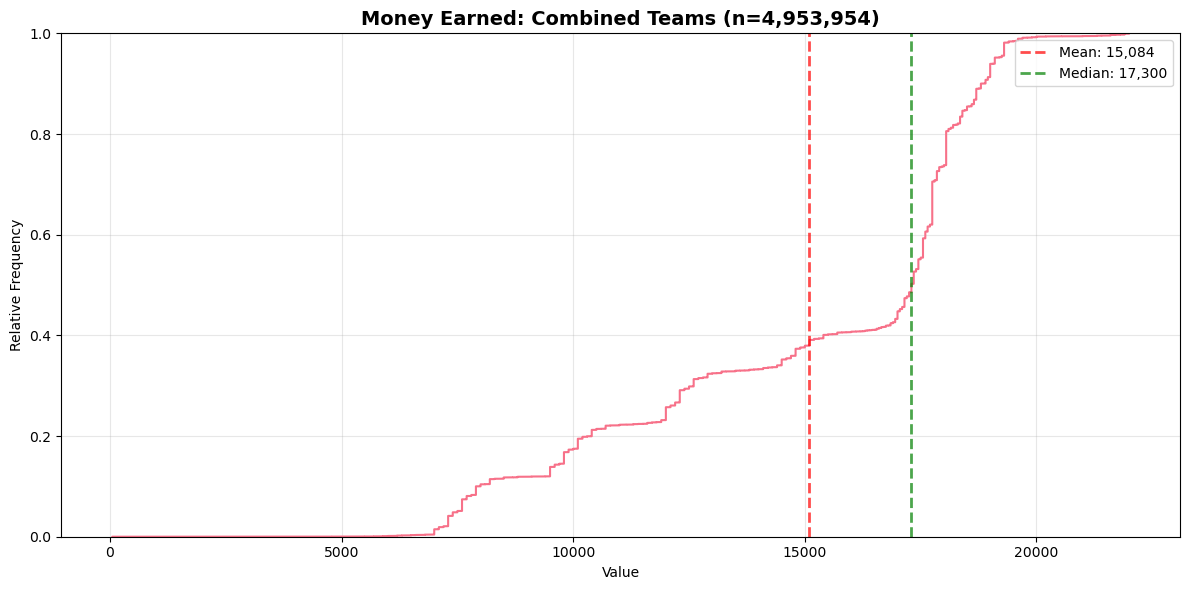

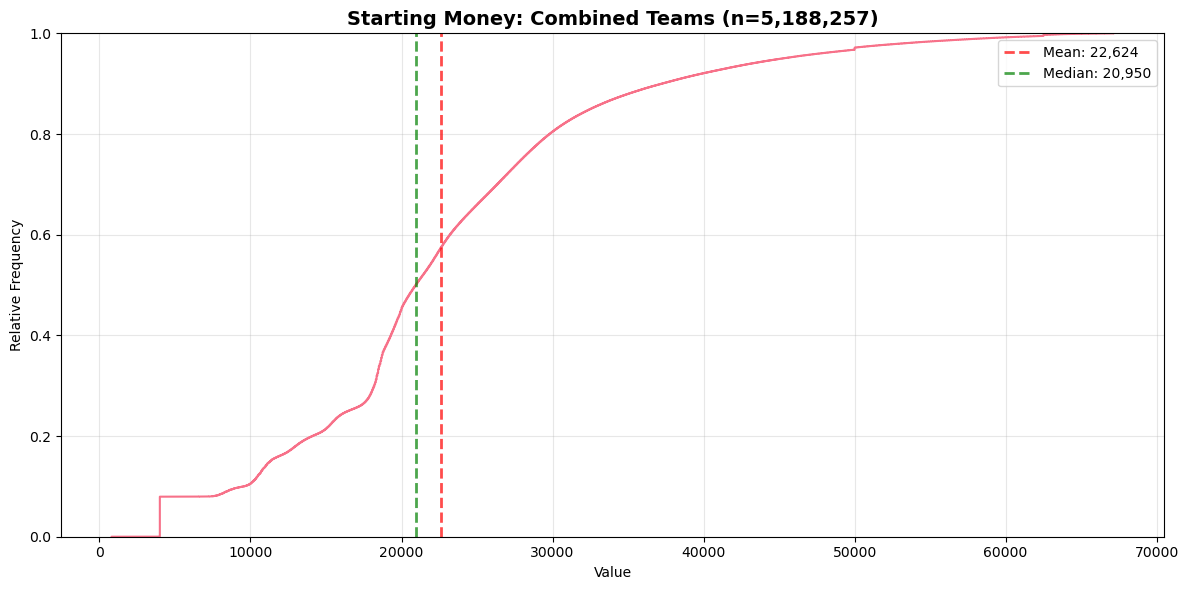

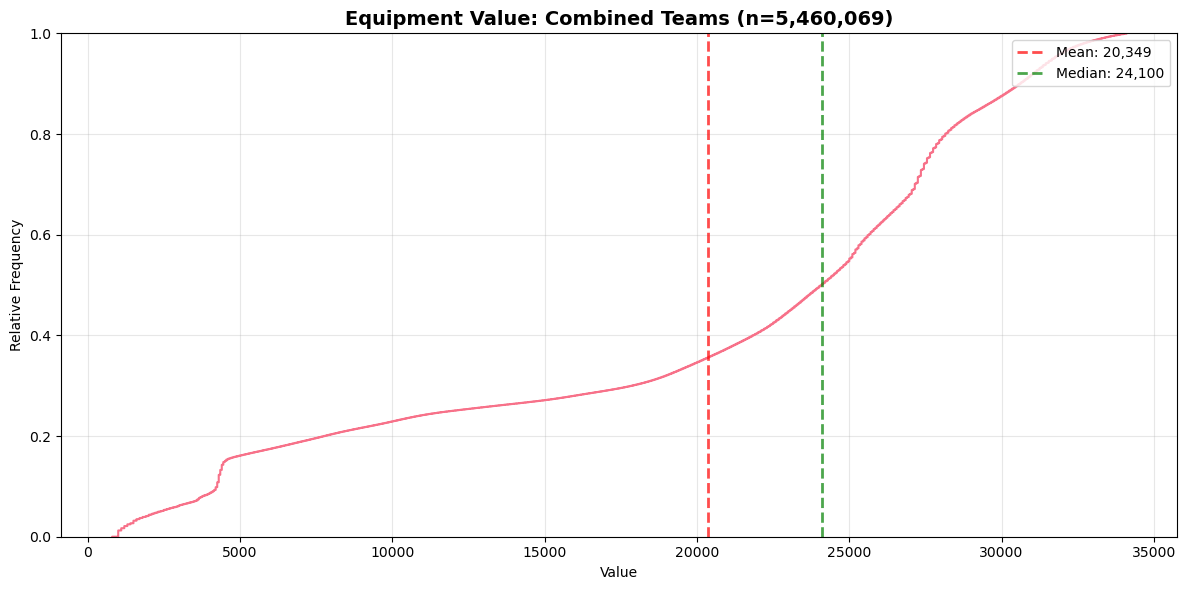

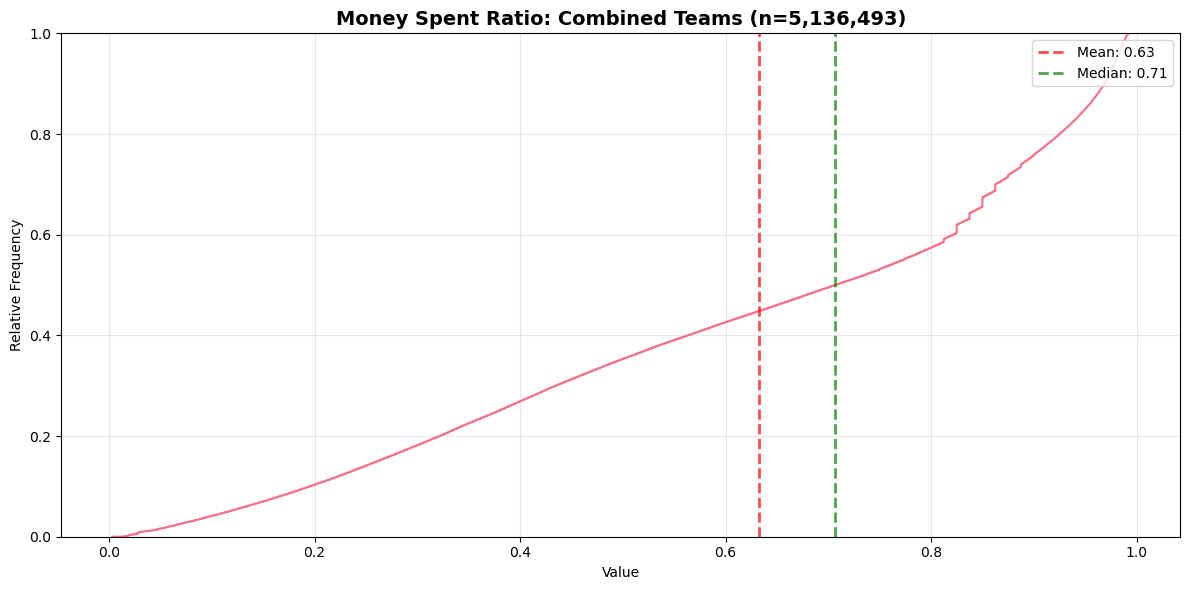

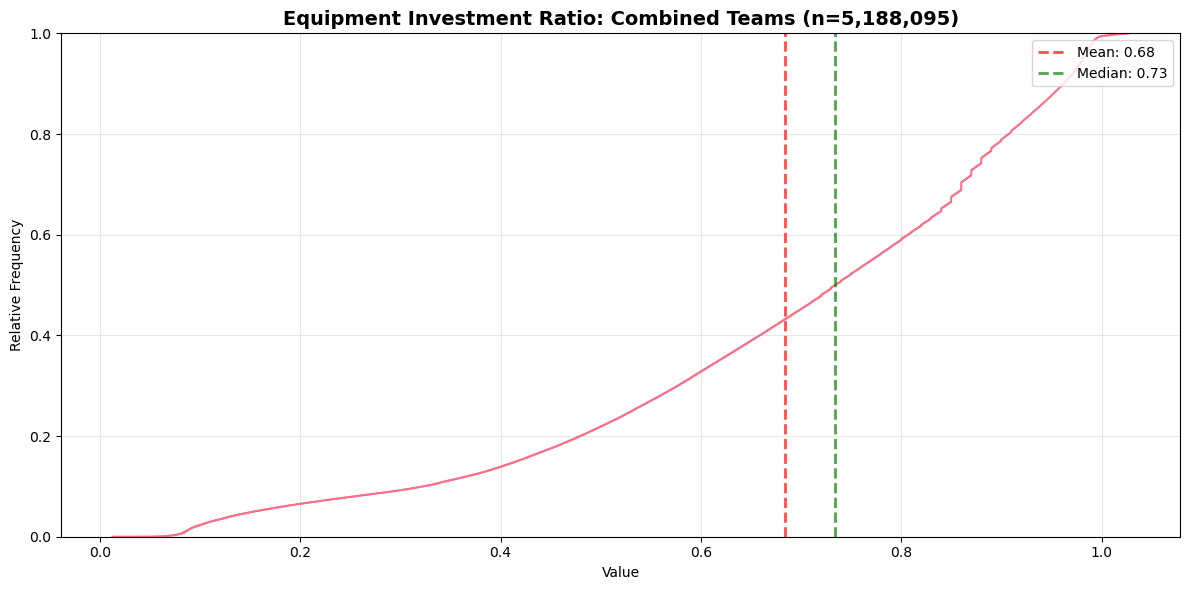

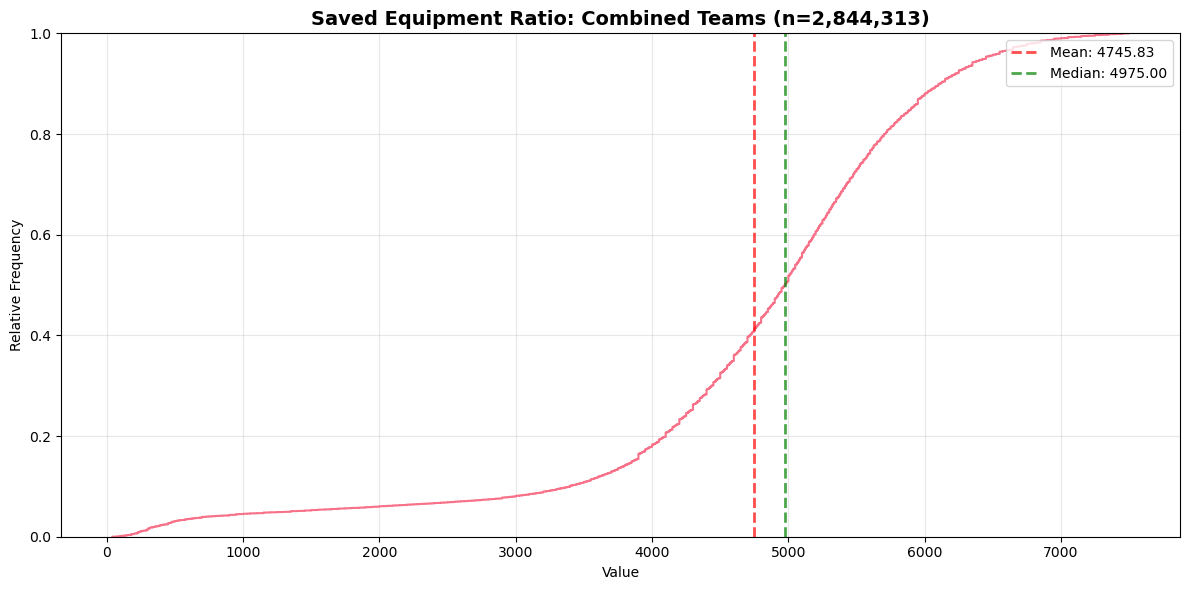

In [9]:
print()
print("="*80)
print("ECONOMY ANALYSIS: COMBINED TEAMS (CT + T)")
print("="*80)
print()

# Create combined overlapping histograms for each variable
for ct_var, t_var, label in team_variables:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # CT Team Data
    ct_clean = economy_df[ct_var].dropna()
    ct_clean = ct_clean[ct_clean > 0]
    
    # T Team Data
    t_clean = economy_df[t_var].dropna()
    t_clean = t_clean[t_clean > 0]

    
    if len(ct_clean) > 0 and len(t_clean) > 0:
        # Apply 99th percentile filter to both
        q99_ct = np.percentile(ct_clean, 99)
        q99_t = np.percentile(t_clean, 99)
        
        ct_viz = ct_clean[ct_clean <= q99_ct]
        t_viz = t_clean[t_clean <= q99_t]
        
        # Combine both teams into single dataset
        combined_data = pd.concat([ct_viz, t_viz])
        
        # Plot combined histogram
        ax.ecdf(combined_data)
        
        # Add statistics for combined data
        combined_mean = combined_data.mean()
        combined_median = combined_data.median()
        
        combined_mean_label = f'{combined_mean:.2f}' if 'ratio' in ct_var else f'{combined_mean:,.0f}'
        combined_median_label = f'{combined_median:.2f}' if 'ratio' in ct_var else f'{combined_median:,.0f}'
        ax.axvline(combined_mean, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Mean: {combined_mean_label}')
        ax.axvline(combined_median, color='green', linestyle='--', linewidth=2, alpha=0.7, label=f'Median: {combined_median_label}')
        
        ax.set_title(f'{label}: Combined Teams (n={len(combined_data):,})', fontsize=14, fontweight='bold')
        ax.set_xlabel('Value')
        ax.set_ylabel('Relative Frequency')
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

                

ROUND END REASON DISTRIBUTION



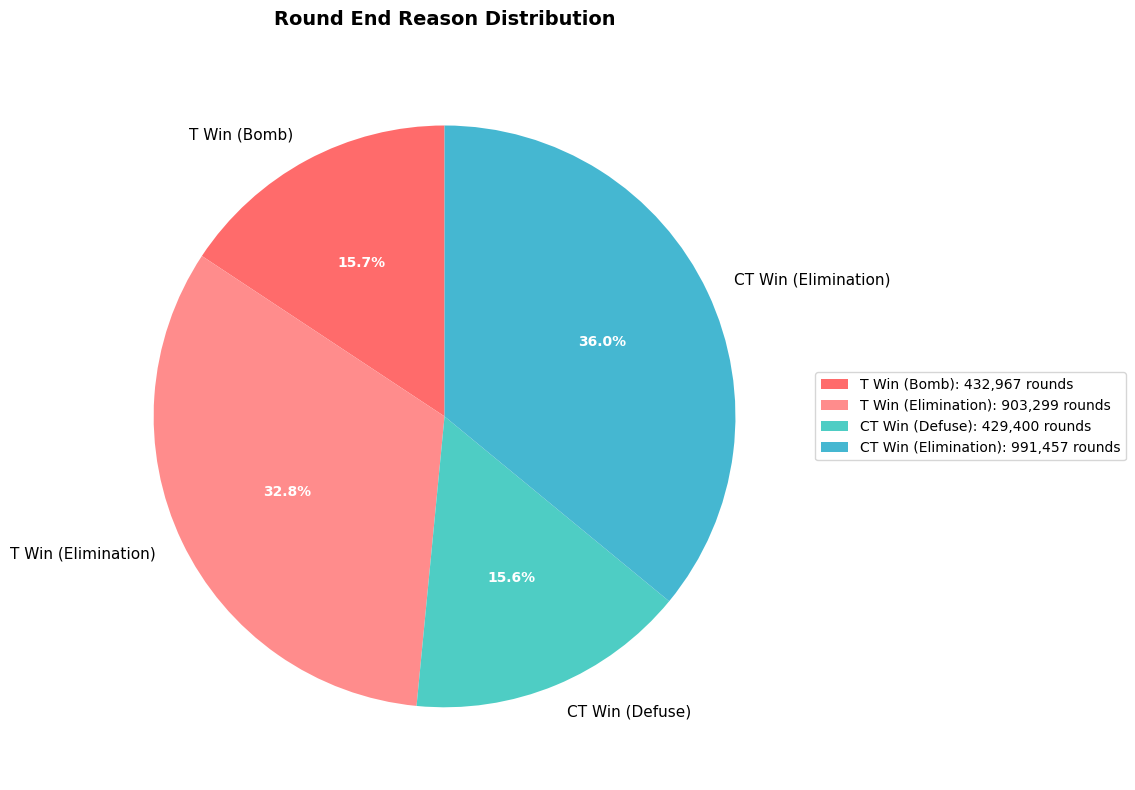

Round End Reason Statistics:
--------------------------------------------------------------------------------
  T Win (Bomb)                  :    432,967 rounds ( 15.7%)
  T Win (Elimination)           :    903,299 rounds ( 32.8%)
  CT Win (Defuse)               :    429,400 rounds ( 15.6%)
  CT Win (Elimination)          :    991,457 rounds ( 36.0%)

Total Rounds: 2,757,123


In [10]:
print("="*80)
print("ROUND END REASON DISTRIBUTION")
print("="*80)
print()

# Define reason labels
reason_labels = {
    1: 'T Win (Bomb)',
    2: 'T Win (Elimination)',
    3: 'CT Win (Defuse)',
    4: 'CT Win (Elimination)'
}

# Count round end reasons
reason_counts = detailed_df['round_end_reason'].value_counts().sort_index()
reason_names = [reason_labels[r] for r in reason_counts.index]

# Create pie chart
fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#ff6b6b', '#ff8c8c', '#4ecdc4', '#45b7d1']
wedges, texts, autotexts = ax.pie(reason_counts, 
                                    labels=reason_names, 
                                    autopct='%1.1f%%',
                                    colors=colors,
                                    startangle=90,
                                    textprops={'fontsize': 11})

# Enhance text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

ax.set_title('Round End Reason Distribution', fontsize=14, fontweight='bold', pad=20)

# Add legend with counts
legend_labels = [f'{reason_names[i]}: {reason_counts.iloc[i]:,} rounds' 
                 for i in range(len(reason_names))]
ax.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

# Print statistics
print("Round End Reason Statistics:")
print("-"*80)
for reason_id in sorted(reason_counts.index):
    count = reason_counts[reason_id]
    pct = (count / reason_counts.sum()) * 100
    print(f"  {reason_labels[reason_id]:30s}: {count:>10,} rounds ({pct:>5.1f}%)")

print()
print(f"Total Rounds: {reason_counts.sum():,}")
print("="*80)

In [ ]:
#TODO: do not show the scoreline 15:15 those are some rare ties that seem to have occured

scores = (
    detailed_df.sort_values(['id_demo_exports', 'round_num'])
    .groupby('id_demo_exports')
    .agg(t1_final=('t1_score_end', 'last'), t2_final=('t2_score_end', 'last'))
    .reset_index()
).copy()

# Prepare helpers
scores['total_rounds'] = scores['t1_final'] + scores['t2_final']
scores['higher'] = scores[['t1_final', 't2_final']].max(axis=1)
scores['lower'] = scores[['t1_final', 't2_final']].min(axis=1)
scores['canon'] = scores['higher'].astype(int).astype(str) + ':' + scores['lower'].astype(int).astype(str)  # e.g., "16:14"
t1_won_mask = scores['t1_final'] > scores['t2_final']
t2_won_mask = ~t1_won_mask


# 2) Overall canonical scorelines (treat 16:14 = 14:16)
canon_overall = (
    scores.groupby(['higher', 'lower', 'canon'])
    .size()
    .reset_index(name='count')
)
canon_overall['total_rounds'] = canon_overall['higher'] + canon_overall['lower']
canon_overall['pct'] = (canon_overall['count'] / len(scores) * 100).round(2)
canon_overall = canon_overall.sort_values(['total_rounds', 'higher', 'lower']).set_index('canon')[['count', 'pct', 'total_rounds']]


canon_overall['cumulative_pct'] = canon_overall['pct'].cumsum()


# Display

print(f"""
Game Length and Scoreline Analysis
Overall canonical scorelines (winner:loser):
{canon_overall[['total_rounds','count', 'pct', 'cumulative_pct']].to_string()}""")

# Final game outcomes
game_scores = detailed_df.groupby('id_demo_exports')[['t1_score_end','t2_score_end', 'team1_winner', 'round_num']].agg({'t1_score_end': 'max', 't2_score_end': 'max', 'team1_winner': 'last', 'round_num': 'max'}).copy()
t1_overall_win = set(game_scores[game_scores['t1_score_end'] > game_scores['t2_score_end']].index)
t2_overall_win = set(game_scores[game_scores['t2_score_end'] > game_scores['t1_score_end']].index)






Game Length and Scoreline Analysis
Overall canonical scorelines (winner:loser):
       total_rounds  count    pct  cumulative_pct
canon                                            
16:0             16     44   0.04            0.04
16:1             17   1183   1.20            1.24
16:2             18   2267   2.29            3.53
16:3             19   3122   3.16            6.69
16:4             20   4135   4.18           10.87
16:5             21   5167   5.22           16.09
16:6             22   6305   6.37           22.46
16:7             23   6890   6.96           29.42
16:8             24   7693   7.78           37.20
16:9             25   8101   8.19           45.39
16:10            26   8411   8.50           53.89
16:11            27   8692   8.79           62.68
16:12            28   8874   8.97           71.65
16:13            29   8917   9.01           80.66
15:15            30     26   0.03           80.69
16:14            30   9952  10.06           90.75
19:15            34

In [ ]:
#TODO: add ct/t side win streaks as well. Maybe change the sql query for that

# T1 streaks ending due to loss after win streak (halftime automatically included) or game end
t1_streaks_end = detailed_df[
    ((detailed_df['t1_win_streak'] == 0) & 
    (detailed_df['t1_loss_streak'] == 1) & (detailed_df['t1_win_streak_prev'] > 0))     
].copy().rename(columns={'t1_win_streak_prev': 'win_streak'})


# Get last round of each game for T1 winners
last_round_t1_winners = detailed_df[detailed_df['team1_winner'] == True].groupby('id_demo_exports')['round_num'].max()
is_last_round_t1_winner = (detailed_df['team1_winner'] == True) & (detailed_df['round_num'] == detailed_df['id_demo_exports'].map(last_round_t1_winners))
t1_last_round_winners = detailed_df[is_last_round_t1_winner].copy().rename(columns={'t1_win_streak': 'win_streak'})

t1_streaks_end = pd.concat([t1_streaks_end, t1_last_round_winners], ignore_index=True)


# T2 streaks ending due to loss after win streak or at halftime or game end
t2_streaks_end = detailed_df[
     ((detailed_df['t2_win_streak'] == 0) & 
    (detailed_df['t2_loss_streak'] == 1) & (detailed_df['t2_win_streak_prev'] > 0)) 
].copy().rename(columns={'t2_win_streak_prev': 'win_streak'})

# Get last round of each game for T2 winners
last_round_t2_winners = detailed_df[detailed_df['team1_winner'] == False].groupby('id_demo_exports')['round_num'].max()
is_last_round_t2_winner = (detailed_df['team1_winner'] == False) & (detailed_df['round_num'] == detailed_df['id_demo_exports'].map(last_round_t2_winners))
t2_last_round_winners = detailed_df[is_last_round_t2_winner].copy().rename(columns={'t2_win_streak': 'win_streak'})

t2_streaks_end = pd.concat([t2_streaks_end, t2_last_round_winners], ignore_index=True)





In [14]:
# Merging Streak data to form one dataframe of the reversals, halftime and game end

# Add is_t1_streak column to identify which team's streak ended
t1_streaks_end['is_t1_streak'] = True
t2_streaks_end['is_t1_streak'] = False

# Combine both streak dataframes
game_reversals = pd.concat([t1_streaks_end, t2_streaks_end]).copy()

# Sort by game_id and round_number for better readability
game_reversals = game_reversals.sort_values(['id_demo_exports', 'round_num']).reset_index(drop=True)

# print(game_reversals[game_reversals['game_id'] == random_game_id])

C:\Users\peter\AppData\Local\Temp\ipykernel_48604\2685331091.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


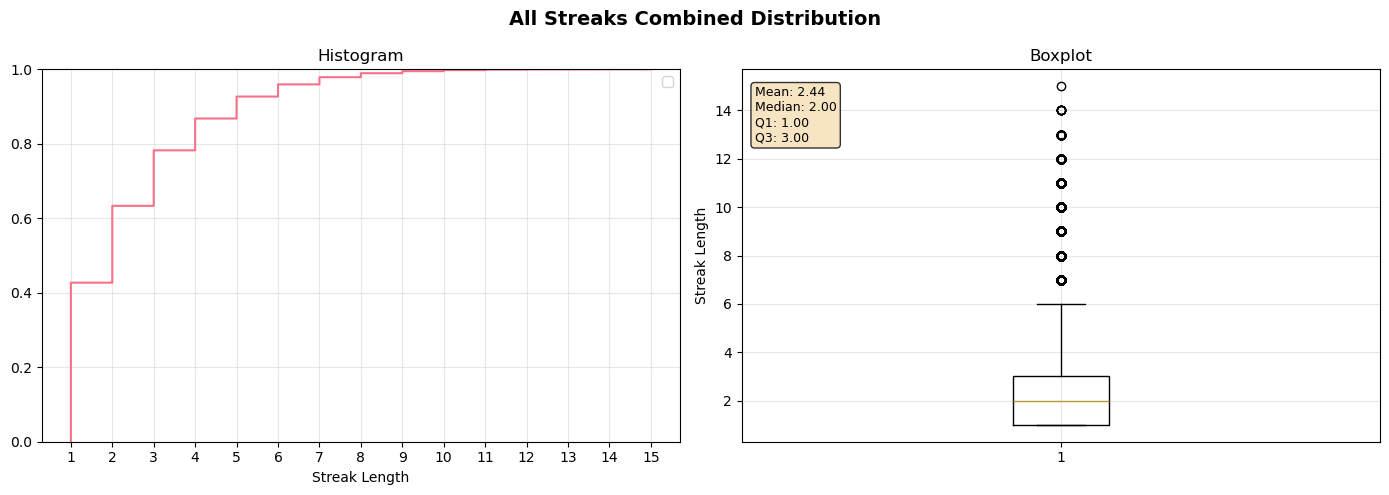

In [29]:
# Create combined boxplot and histogram for all streak data
streak_columns = ['win_streak']

# Combine all streak data
combined_streaks = pd.concat([game_reversals[col].dropna() for col in streak_columns if col in game_reversals.columns])

if len(combined_streaks) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('All Streaks Combined Distribution', fontsize=14, fontweight='bold')
    
    # Histogram
    ax1.ecdf(combined_streaks)
    ax1.set_xlabel('Streak Length')
    ax1.set_title('Histogram')
    ax1.grid(True, alpha=0.3)
    # Show each x-axis value
    unique_values = sorted(combined_streaks.unique())
    ax1.set_xticks(unique_values)
    ax1.legend()
    
    # Boxplot
    ax2.boxplot(combined_streaks, vert=True)
    ax2.set_ylabel('Streak Length')
    ax2.set_title('Boxplot')
    ax2.grid(True, alpha=0.3)

    # Add statistics
    mean_val = combined_streaks.mean()
    median_val = combined_streaks.median()
    q1_val = combined_streaks.quantile(0.25)
    q3_val = combined_streaks.quantile(0.75)
    ax2.text(0.52, 15, 
                    f'Mean: {mean_val:.2f}\nMedian: {median_val:.2f}\nQ1: {q1_val:.2f}\nQ3: {q3_val:.2f}',
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                    fontsize=9)
    
    plt.tight_layout()
    plt.show()

